In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # blacklist tf warning and info
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py

/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/songzitao/anaconda3/envs/py36/lib

In [2]:
from matplotlib import pyplot as plt
from matplotlib import animation
import json
%matplotlib inline
from environment.portfolio import PortfolioEnv
eps=1e-8

In [3]:
with h5py.File('./Data/history_stock_price_us_22.h5','r') as f:
    history_stock_price = f['stock_price'][...]
    timestamp = [s.decode('utf-8') for s in f['timestamp']]
    abbreviations = [s.decode('utf-8') for s in f['abbreviations']]
    features = [s.decode('utf-8') for s in f['features']]

In [5]:
features

['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'SAR', 'RSI', 'BOLL', 'MACD']

In [4]:
train_step = timestamp.index('2017-06-29')
valid_step = timestamp.index('2019-07-01')

In [5]:
history_stock_price_training = history_stock_price[:,:train_step,:9]
history_stock_price_validating = history_stock_price[:,train_step:valid_step,:9]
history_stock_price_testing = history_stock_price[:,valid_step:,:9]
timestamp_training = timestamp[:train_step]
timestamp_validating = timestamp[train_step:valid_step]
timestamp_testing = timestamp[valid_step:]

# Load Pre-Trained Models

In [74]:
model_a = {'name':'ddpg','window_size':10,'detrend':False,'tau':1.0,'beta':0.0,'n_step':1,
           'mixture':3,'epi':100,'best':False,'region':'us'}

model_b = {'name':'td3','window_size':10,'detrend':False,'tau':1.0,'beta':0.0,'n_step':1,
           'mixture':3,'epi':100,'best':True,'region':'us'}

model_c = {'name':'d3pg','window_size':10,'detrend':False,'tau':1.0,'beta':0.0,'n_step':1,
           'mixture':3,'epi':5,'best':False,'region':'us'}

model_d = {'name':'sac','window_size':10,'detrend':False,'tau':1.0,'beta':0.0,'n_step':1,
           'mixture':3,'epi':100,'best':True,'region':'us'}

model_e = {'name':'ppo','window_size':10,'detrend':False,'tau':1.0,'beta':0.0,'n_step':5,
           'mixture':3,'epi':2000,'best':False,'region':'us'}

model_f = {'name':'qrsac','window_size':20,'detrend':False,'tau':1.0,'beta':0.5,'n_step':1,
           'mixture':3,'epi':50,'best':True,'region':'us'}

model_configs = [model_a,model_b,model_c,model_d,model_e,model_f]

In [75]:
from model.ddpg.stockactor import DDPGActor
from model.ddpg.stockcritic import DDPGCritic
from model.qrsac.stockcritic import QRCritic
from model.ddpg.ddpg import DDPG
from model.sac.stockactor import SACActor
from model.td3.td3 import TD3
from model.sac.sac import SAC
from model.qrsac.qrsac import QRSAC
from model.core.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

In [76]:
from train import get_path, get_variable_scope, test_model, test_model_multiple, \
               obs_normalizer, normalize_obs_logdiff, normalize_obs_diff_2

In [77]:
models = []
model_names = []
for model_config in model_configs:
    window_size = model_config['window_size']
    #use_obs_normalizer = model_config['obs_norm']
    num_mixture = model_config['mixture']
    this_model = model_config['name']
    tau_softmax = model_config['tau']
    with open('configs/{}_default_highassets_3.json'.format(this_model)) as f:
        config = json.load(f)
        
    actor_layers = config['actor_layers']
    critic_layers = config['critic_layers']
    asset_number = config['input']['asset_number']
    feature_number = config['input']['feature_number']
    actor_learning_rate = 0.0
    critic_learning_rate = 0.0
    lam = config['training'].get('lam',0)
    ppo_eps = config['training'].get('ppo_eps',0)
    ent_coef = config['training'].get('ent_coef',0)
    tau = 0.0
    batch_size = 0
    policy_delay = 1
    
    num_quart = config['training'].get('num_quart',None)
    name = '%s_WIN%s_MIX%s_%s'%(model_config['name'],
                                        model_config['window_size'],
                                         str(model_config['mixture']),
                                         model_config['region'])
    model_names.append(name)
    model_save_path = get_path('weights',model = model_config['name'],
                                         episode=model_config['epi'],
                                         window_size=model_config['window_size'],
                                         region=model_config['region'],
                                         beta=model_config['beta'],
                                         tau=model_config['tau'],
                                         n_step=model_config['n_step'],
                                         best=model_config['best'],
                                         detrend=model_config['detrend'],
                                          num_mixture=model_config['mixture'])

    print(model_save_path)
    #model_save_path = './weights/best_sac/sac.ckpt'

    variable_scope = get_variable_scope(window_size=model_config['window_size'],
                                        beta=model_config['beta'],
                                        num_mixture=model_config['mixture'],
                                        tau=model_config['tau'])

    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(asset_number+1))

    tf.reset_default_graph()
    if model_config['detrend']:
#        obs_normalizer = normalize_obs_diff_2
#         window_size_ = window_size
        obs_normalizer = normalize_obs_logdiff
        window_size_ = window_size - 1
    else:
        obs_normalizer = normalize_obs_diff_2
        window_size_ = window_size
    with tf.variable_scope(variable_scope):
        sess = tf.Session()
        with tf.variable_scope('actor'):
            if this_model[-3:] =='sac':
                dtype = tf.float64
                tf.keras.backend.set_floatx('float64')
                stockactor = SACActor(sess, feature_number = feature_number,
                                              config = config,
                                              action_dim = asset_number + 1,
                                              window_size = window_size_,
                                              num_mixture = num_mixture,
                                              learning_rate = actor_learning_rate,
                                              action_bound=1,
                                              layers = actor_layers,
                                              tau_softmax= tau_softmax,
                                              num_vars=0,
                                              tau=tau, batch_size=batch_size,dtype=dtype)
            elif this_model == 'ppo':
                dtype = tf.float64
                tf.keras.backend.set_floatx('float64')
                from model.ppo.stockactor import PPOActor
                stock_actor = PPOActor(sess=sess,
                                        config=config,
                                        feature_number=feature_number,
                                        action_dim=asset_number + 1,
                                        window_size=window_size_,
                                        ent_coef=ent_coef,
                                        num_mixture=num_mixture,
                                        learning_rate=actor_learning_rate,
                                        layers=actor_layers,
                                        tau_softmax = tau_softmax,
                                        num_vars=0,
                                        dtype=dtype)
            else:
                dtype = tf.float32
                tf.keras.backend.set_floatx('float32')
                stockactor = DDPGActor(sess, feature_number = feature_number,
                                              config = config,
                                              action_dim = asset_number + 1,
                                              window_size = window_size_,
                                              learning_rate = actor_learning_rate,
                                              action_bound=1,
                                              layers = actor_layers,
                                              num_vars=0,
                                              tau=tau, batch_size=batch_size)
        with tf.variable_scope('critic'):
            if this_model[:2] =='qr':

                stockcritic = QRCritic(sess,    feature_number = feature_number,
                                    config = config,
                                    action_dim = asset_number+1,
                                    window_size = window_size_,
                                    num_quart = num_quart,
                                    learning_rate = critic_learning_rate,
                                    num_actor_vars = stockactor.get_num_trainable_vars(),
                                    layers = critic_layers,
                                    tau=tau, batch_size=batch_size,dtype=dtype)
                
            elif this_model == 'd3pg':
                from model.d3pg.stockcritic import QRCritic
                stockcritic = QRCritic(sess,    feature_number = feature_number,
                                                config = config,
                                                action_dim = asset_number+1,
                                                window_size = window_size_,
                                                num_quart = num_quart,
                                                learning_rate = critic_learning_rate,
                                                num_actor_vars = stockactor.get_num_trainable_vars(),
                                                layers = critic_layers,
                                                tau=tau, batch_size=batch_size,dtype=dtype)
            elif this_model == 'ppo':
                from model.ppo.stockcritic import PPOCritic
                stock_critic = PPOCritic(sess=sess,
                                       config=config,
                                       feature_number=feature_number,
                                       action_dim=asset_number + 1,
                                       window_size=window_size_,
                                       learning_rate=critic_learning_rate,
                                       layers=critic_layers,
                                       num_actor_vars=stock_actor.get_num_trainable_vars(),
                                       dtype=dtype)
            else:
                stockcritic = DDPGCritic(sess, feature_number = feature_number,
                                                config = config,
                                                action_dim = asset_number+1,
                                                window_size = window_size_,
                                                learning_rate = critic_learning_rate,
                                                num_actor_vars = stockactor.get_num_trainable_vars(),
                                                layers = critic_layers,
                                                tau=tau, batch_size=batch_size,dtype=dtype)


        if this_model == 'ddpg':
            print('loading ddpg')
            model = DDPG(None,None,sess, actor = stockactor,
                                             critic = stockcritic,
                                             obs_normalizer = obs_normalizer,
                                             actor_noise = actor_noise,
                                             model_save_path = model_save_path,
                                             config = config)

        elif this_model == 'td3' or this_model == 'sac':
            with tf.variable_scope('critic'):
                stockcritic2 = DDPGCritic(sess, feature_number = feature_number,
                                                 config = config,
                                                 action_dim = asset_number+1,
                                                 window_size = window_size_,
                                                 learning_rate = critic_learning_rate,
                                                 num_actor_vars = stockactor.get_num_trainable_vars() + stockcritic.get_num_trainable_vars(),
                                                 layers = critic_layers,
                                                 tau=tau, batch_size=batch_size,dtype=dtype)
            if this_model == 'td3':
                print('loading td3')
                model = TD3(None,None, sess,  actor = stockactor,
                                                 critic1 = stockcritic,
                                                 critic2 = stockcritic2,
                                                 obs_normalizer = obs_normalizer,
                                                 actor_noise = actor_noise,
                                                 policy_delay = policy_delay,
                                                 model_save_path = model_save_path,

                                                 config = config)
            else:
                print('loading sac')
                model = SAC(None,None,sess,  actor = stockactor,
                                                 critic1 = stockcritic,
                                                 critic2 = stockcritic2,
                                                 obs_normalizer = obs_normalizer,
                                                 actor_noise = actor_noise,
                                                 policy_delay = policy_delay,
                                                 model_save_path = model_save_path,
                                                 config = config)
        elif this_model == 'd3pg':
            from model.d3pg.d3pg import D3PG
            model = D3PG(None ,None,sess, actor = stockactor,
                                            critic = stockcritic,
                                            obs_normalizer = obs_normalizer,
                                            actor_noise = actor_noise,
                                            model_save_path = model_save_path,
                                            config = config)
        elif this_model =='ppo':
            from model.ppo.ppo import PPO
            model = PPO(None,None,
                           sess=sess,
                           actor=stock_actor,
                           critic=stock_critic,
                           actor_noise=actor_noise,
                           obs_normalizer=obs_normalizer,
                           config=config,
                           lam=lam,
                           model_save_path = model_save_path)
        
        elif this_model == 'qrsac':
            print("loading qrsac")
            model = QRSAC(None,None, sess,  actor = stockactor,
                                 critic = stockcritic,
                                 obs_normalizer = obs_normalizer,
                                 actor_noise = actor_noise,
                                 policy_delay = policy_delay,
                                 model_save_path = model_save_path,
                                 config = config)
        else:
            raise("Model not Implemented Error")

        model.initialize(load_weights=True, verbose=False)  # change to True to load weights
        models.append(model)

weights/ddpg/window_10_detrend_False_eps_100_mix_3_step_1_beta_0.0_tau_1.0_us_checkpoint.ckpt
loading ddpg
INFO:tensorflow:Summary name step target loss is illegal; using step_target_loss instead.
INFO:tensorflow:Summary name step Q max is illegal; using step_Q_max instead.
INFO:tensorflow:Summary name step target loss is illegal; using step_target_loss instead.
INFO:tensorflow:Summary name step Q max is illegal; using step_Q_max instead.
Initializing rank_based.Experience()
INFO:tensorflow:Restoring parameters from weights/ddpg/window_10_detrend_False_eps_100_mix_3_step_1_beta_0.0_tau_1.0_us_checkpoint.ckpt
weights/best_td3/window_10_detrend_False_eps_100_mix_3_step_1_beta_0.0_tau_1.0_us_checkpoint.ckpt
loading td3
Initializing rank_based.Experience()
INFO:tensorflow:Restoring parameters from weights/best_td3/window_10_detrend_False_eps_100_mix_3_step_1_beta_0.0_tau_1.0_us_checkpoint.ckpt
weights/d3pg/window_10_detrend_False_eps_5_mix_3_step_1_beta_0.0_tau_1.0_us_checkpoint.ckpt
Initi

# Validating and Testing

In [78]:
validation_start_date = '2017-09-13'
test_start_date = '2019-09-16'
val_steps = 300
test_steps= 200
max_window_length = 50

In [79]:
Env_validating = PortfolioEnv(history=history_stock_price_validating,
                                                abbreviation=abbreviations,
                                                timestamp=timestamp_validating,
                                                window_length=max_window_length,
                                                steps=val_steps,
                                                sample_start_date=validation_start_date,
                                                feature_num=feature_number)

Env_testing = PortfolioEnv(history=history_stock_price_testing,
                                                abbreviation=abbreviations,
                                                timestamp=timestamp_testing,
                                                window_length=max_window_length,
                                                steps=test_steps,
                                                sample_start_date=test_start_date,
                                                feature_num=feature_number)

In [95]:
Env_infos = []
Env = Env_validating
for i in range(len(models)):
    env = test_model(Env,models[i],policy_delay=1)
    Env_infos.append(pd.DataFrame(env.infos))

ic| self.step: 1
ic| self.step: 2
ic| self.step: 3
ic| self.step: 4
ic| self.step: 5
ic| self.step: 6
ic| self.step: 7
ic| self.step: 8
ic| self.step: 9
ic| self.step: 10
ic| self.step: 11
ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| 

Start date: 2017-09-13, End date: 2018-11-20


self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.step: 72
ic| self.step: 73
ic| self.step:

Start date: 2017-09-13, End date: 2018-11-20


ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.step: 72
ic| self.step: 73
ic| self.s

Start date: 2017-09-13, End date: 2018-11-20


ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.step: 72
ic| self.step: 73
ic| self.s

Start date: 2017-09-13, End date: 2018-11-20


ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.s

Start date: 2017-09-13, End date: 2018-11-20


ic| self.step: 10
ic| self.step: 11
ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.s

Start date: 2017-09-13, End date: 2018-11-20


ic| self.step: 9
ic| self.step: 10
ic| self.step: 11
ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.st

In [97]:
import seaborn as sns

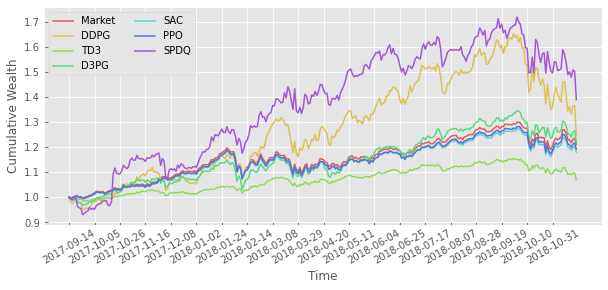

In [98]:
fig, ax = plt.subplots(figsize = (10,4))
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)
plt.style.use('ggplot')
ax.grid(True)
palette = sns.color_palette("hls", 8)
for i in range(0,len(model_names)):
    envs_df = Env_infos[i]
    if i == 0:
        # plot market value
        ax.plot(np.arange(0,len(envs_df)),envs_df['market_value'].to_numpy(),label='market',color=palette[0])
    ax.plot(np.arange(0,len(envs_df)),envs_df['portfolio_value'].to_numpy(),label=model_names[i].split('_')[0],color=palette[i+1])

ax.set_xticks(np.arange(0,len(envs_df))[::15])
ax.set_xticklabels(envs_df['date'].to_numpy()[::15], rotation='30')
ax.set_ylabel('Cumulative Wealth')
ax.set_xlabel('Time')
ax.tick_params(axis="both", direction='in')
ax.legend(['Market','DDPG','TD3','D3PG','SAC','PPO','SPDQ'],loc = 'best',prop={'size': 10},ncol=2)
fig.savefig('./figs/valid_cumulative_wealth.pdf',pad_inches=0)

# Testing Performance Metrics

In [89]:
from environment.portfolio import sharpe, max_drawdown, AVOL,DDR,ARR

In [90]:
steps = test_steps 
model_names = [name.split('_')[0] for name in model_names]

sharpes_dict = {model_name: [] for model_name in model_names}
sharpes_dict['market_value'] = []
mdd_dict = {model_name: [] for model_name in model_names}
mdd_dict['market_value'] = []

arr_dict = {model_name: [] for model_name in model_names}
arr_dict['market_value'] = []
avol_dict = {model_name: [] for model_name in model_names}
avol_dict['market_value'] = []

ddr_dict = {model_name: [] for model_name in model_names}
ddr_dict['market_value'] = []

asr_dict = {model_name: [] for model_name in model_names}
asr_dict['market_value'] = []
for n in range(3):
    for i in range(len(models)):
        model_name = model_names[i]
        envs = test_model(env=Env_testing,model=models[i], policy_delay=1)
        envs_df = pd.DataFrame(envs.infos)
        
        returns = (envs_df['portfolio_value']/ envs_df['portfolio_value'].shift()) -1
        
        # sharpes_dict[model_name].append(sharpe(returns,freq=steps))
        mdd = max_drawdown(envs_df['portfolio_value'])
        arr = ARR(envs_df['portfolio_value'],freq=steps)
        avol = AVOL((envs_df['portfolio_value']-1),freq=steps)
        ddr = DDR(returns,arr)
                  
                  
        arr_dict[model_name].append(arr)
        avol_dict[model_name].append(avol)
        ddr_dict[model_name].append(ddr)
        asr_dict[model_name].append(arr/avol)
        mdd_dict[model_name].append(mdd)
        
        
    market_returns = (envs_df['market_value']/ envs_df['market_value'].shift()) -1
    # sharpes_dict['market_value'].append(sharpe(market_returns, freq=steps))
    mdd_dict['market_value'].append(max_drawdown(envs_df['market_value']))
    
    arr_market = ARR(envs_df["market_value"],freq=steps)
    avol_market = AVOL((envs_df["market_value"]-1),freq=steps)
    
    avol_dict['market_value'].append(avol_market)
    arr_dict['market_value'].append(arr_market)
    ddr_dict['market_value'].append(DDR(market_returns,arr_market))
    asr_dict['market_value'].append(arr_market/avol_market)

ic| self.step: 1
ic| self.step: 2
ic| self.step: 3
ic| self.step: 4
ic| self.step: 5
ic| self.step: 6
ic| self.step: 7
ic| self.step: 8
ic| self.step: 9
ic| self.step: 10
ic| self.step: 11
ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18


Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.step: 72
ic| self.step: 73
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01



ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 11
ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 10
ic| self.step: 11
ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.step: 72
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 9
ic| self.step: 10
ic| self.step: 11
ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.st

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.step: 72
ic| self.step: 73
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
ic| self.step: 68
ic| self.step: 69
ic| self.step: 70
ic| self.step: 71
ic| self.step: 72
ic| self.step: 73
ic| se

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.s

Start date: 2019-09-16, End date: 2020-07-01


step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 63
ic| self.step: 64
ic| self.step: 65
ic| self.step: 66
ic| self.step: 67
i

Start date: 2019-09-16, End date: 2020-07-01


self.step: 8
ic| self.step: 9
ic| self.step: 10
ic| self.step: 11
ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
ic| self.step: 57
ic| self.step: 58
ic| self.step: 59
ic| self.step: 60
ic| self.step: 61
ic| self.step: 62
ic| self.step: 6

In [96]:
metrics = {'arr':arr_dict,'avol':avol_dict,'asr':asr_dict,'mdd':mdd_dict,'ddr':ddr_dict}

In [92]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,arr,avol,asr,mdd,ddr
ddpg,"[0.2871028037071374, 0.2871028037071374, 0.287...","[0.11197852998833849, 0.11197852998833849, 0.1...","[2.563909382781114, 2.563909382781114, 2.56390...","[-0.35715763343094115, -0.35715763343094115, -...","[1.8069868965850928, 1.8069868965850928, 1.806..."
td3,"[0.08260902212877698, 0.08260902212877698, 0.0...","[0.030410827868303927, 0.030410827868303927, 0...","[2.71643450439826, 2.71643450439826, 2.7164345...","[-0.013408853648327364, -0.013408853648327364,...","[1.7470765314669416, 1.7470765314669416, 1.747..."
d3pg,"[0.3032546719209874, 0.3032546719209874, 0.303...","[0.09324766483657677, 0.09324766483657677, 0.0...","[3.252142264929239, 3.252142264929239, 3.25214...","[-0.036139253218644043, -0.036139253218644043,...","[2.663250007937213, 2.663250007937213, 2.66325..."
sac,"[0.06827813014763731, 0.07630562446205326, 0.0...","[0.07060893463474734, 0.07016305283635692, 0.0...","[0.9669899496548555, 1.087547097473407, 1.0279...","[-0.28266900193924366, -0.2815614316880145, -0...","[0.6506912969675174, 0.7307529160942262, 0.685..."
ppo,"[0.08128052831853283, 0.08096379809158831, 0.0...","[0.0706094286346683, 0.0707223898207355, 0.070...","[1.1511285375084477, 1.1448113998524703, 1.171...","[-0.2810540521791444, -0.2816713488312376, -0....","[0.7828819183362639, 0.7739010306214913, 0.789..."
qrsac,"[0.6314282684017756, 0.6314839128623005, 0.631...","[0.163605655829664, 0.16362621195609056, 0.163...","[3.859452567209408, 3.8593077802947646, 3.8592...","[-0.036077167499958186, -0.03608709239146327, ...","[4.379324608834561, 4.379686536369047, 4.37882..."
market_value,"[0.09073139342413171, 0.09073139342413171, 0.0...","[0.07115377121943042, 0.07115377121943042, 0.0...","[1.2751452504790792, 1.2751452504790792, 1.275...","[-0.281698388816667, -0.281698388816667, -0.28...","[0.8725562795822981, 0.8725562795822981, 0.872..."


In [93]:
metrics_df.applymap(lambda x:np.mean(x))

,arr,avol,asr,mdd,ddr
ddpg,0.287103,0.111979,2.563909,-0.357158,1.806987
td3,0.082609,0.030411,2.716435,-0.013409,1.747077
d3pg,0.303255,0.093248,3.252142,-0.036139,2.663250
sac,0.072368,0.070440,1.027508,-0.282446,0.689126
ppo,0.081617,0.070618,1.155775,-0.281245,0.782244
qrsac,0.631422,0.163609,3.859332,-0.036087,4.379280
market_value,0.090731,0.071154,1.275145,-0.281698,0.872556


# Interpreting

In [99]:
import seaborn as sns

In [100]:
def get_integrated_gradients(inputs, model, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(inputs.shape).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)


    # Get the gradients
    grads = []
    for i, obs in enumerate(interpolated_inputs):
        obs = np.expand_dims(obs, axis=0)
        grad = model.actor.cal_inputs_grad(obs)[0]
        grads.append(grad[0])

    # Approximate the integral using the trapezoidal rule
    grads = grads[:-1] + grads[1:]
    grads = [g / 2 for g in grads]
    avg_grads = np.mean(grads, axis=0)

    # Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

In [101]:
model = models[-1]   # choose a model

In [102]:
observation, _ = Env_testing.reset()
igs = []
done = False
while not done:
    action = model.predict_single(observation)
    pre_action = action
    observation, _, done, _ = Env_testing.step(action)
    obs = observation[:,-window_size_:,:]
    obs = normalize_obs_diff_2(obs)
    ig = get_integrated_gradients(obs,model)
    igs.append(ig)

Start date: 2019-09-16, End date: 2020-07-01


ic| self.step: 1
ic| self.step: 2
ic| self.step: 3
ic| self.step: 4
ic| self.step: 5
ic| self.step: 6
ic| self.step: 7
ic| self.step: 8
ic| self.step: 9
ic| self.step: 10
ic| self.step: 11
ic| self.step: 12
ic| self.step: 13
ic| self.step: 14
ic| self.step: 15
ic| self.step: 16
ic| self.step: 17
ic| self.step: 18
ic| self.step: 19
ic| self.step: 20
ic| self.step: 21
ic| self.step: 22
ic| self.step: 23
ic| self.step: 24
ic| self.step: 25
ic| self.step: 26
ic| self.step: 27
ic| self.step: 28
ic| self.step: 29
ic| self.step: 30
ic| self.step: 31
ic| self.step: 32
ic| self.step: 33
ic| self.step: 34
ic| self.step: 35
ic| self.step: 36
ic| self.step: 37
ic| self.step: 38
ic| self.step: 39
ic| self.step: 40
ic| self.step: 41
ic| self.step: 42
ic| self.step: 43
ic| self.step: 44
ic| self.step: 45
ic| self.step: 46
ic| self.step: 47
ic| self.step: 48
ic| self.step: 49
ic| self.step: 50
ic| self.step: 51
ic| self.step: 52
ic| self.step: 53
ic| self.step: 54
ic| self.step: 55
ic| self.step: 56
i

In [103]:
igs_sum = -np.sum(igs,axis=0) # MINUS SIGN TO MAXIMUM Q
igs_sum.shape

(23, 20, 10)

In [104]:
features_ = features + ['WEIGHTS']
time = np.arange(-(20-1),1,1)

In [105]:
vmin = np.min(igs_sum)
vmax = np.max(igs_sum)

In [106]:
xv, yv = np.meshgrid(np.arange(0,6,1),np.arange(0,4,1))

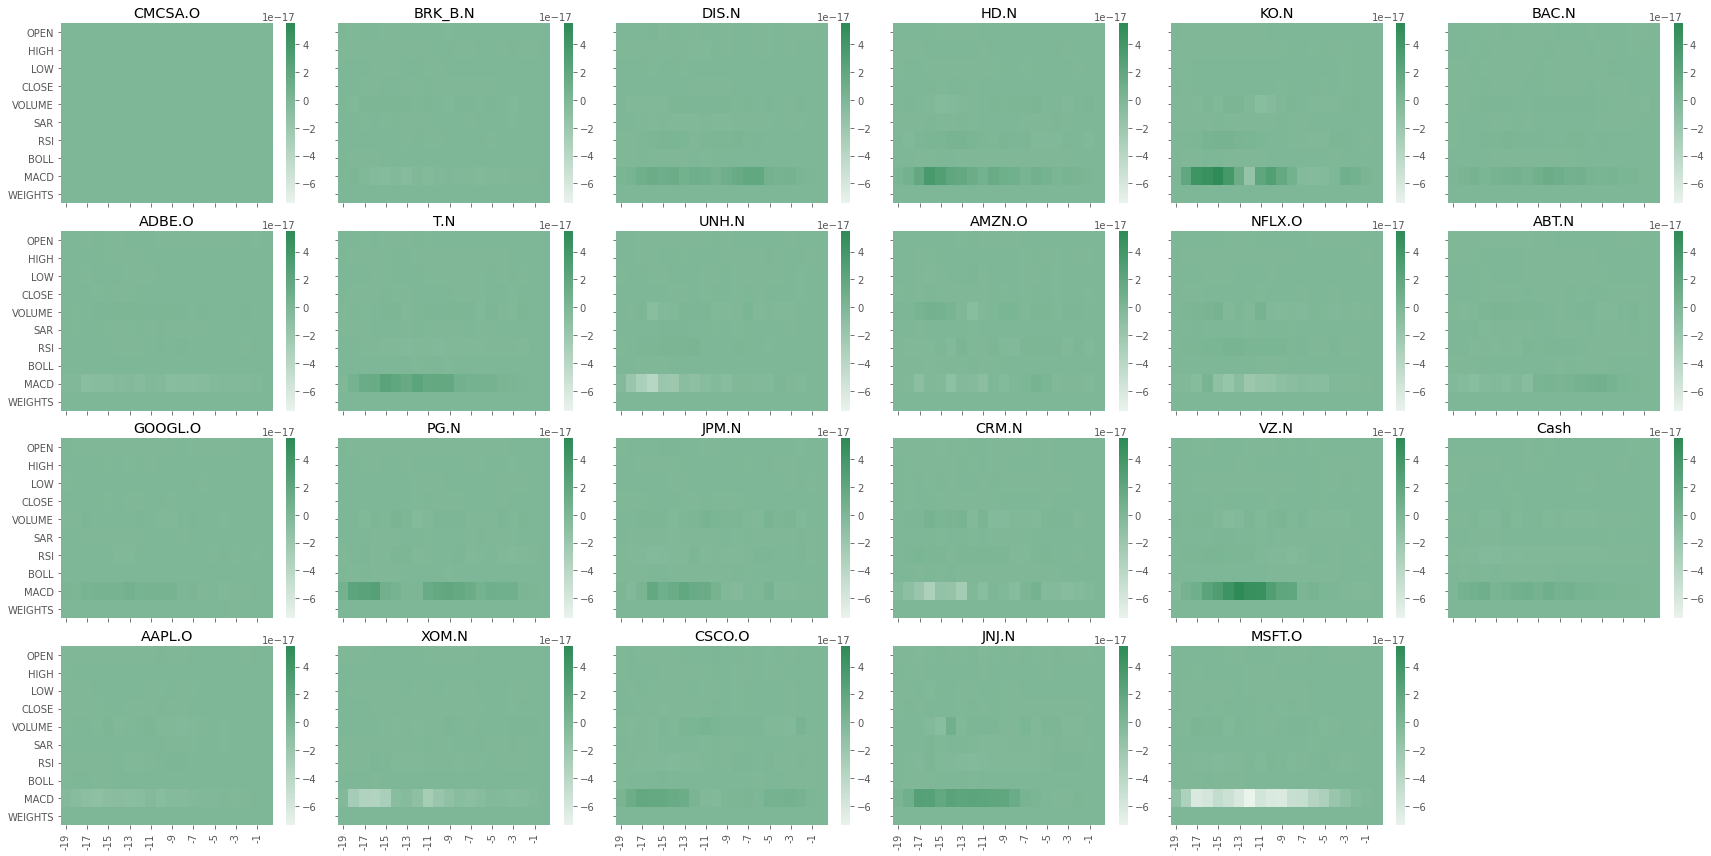

In [107]:
fig, ax = plt.subplots(nrows=4,ncols=6, sharex=True,sharey=True,figsize=(24,12))
counter = 0
for i in range(6):
    for j in range(4):
        df = pd.DataFrame(data=igs_sum[counter,:,:].T, columns=time, index=features_)
        sns.heatmap(df,ax=ax[j,i], vmin=vmin, vmax=vmax,cmap=sns.light_palette("seagreen", as_cmap=True))
        if counter >= asset_number:
            ax[j,i].set_title('Cash')
            break
        else:
            ax[j,i].set_title(abbreviations[counter])
        counter += 1
    if counter > asset_number:
        break
fig.delaxes(ax[3,5])
plt.tight_layout()

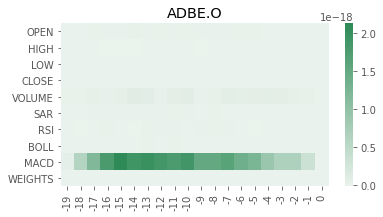

In [68]:
fig, ax = plt.subplots(nrows=1,ncols=1, sharex=True,sharey=True,figsize=(6,3))
df = pd.DataFrame(data=igs_sum[1,:,:].T, columns=time, index=features_)
sns.heatmap(df,ax=ax,cmap=sns.light_palette("seagreen", as_cmap=True))
ax.set_title(abbreviations[1])
fig.savefig('./figs/case_study_adbe_ig.pdf',pad_inches=0)

# Sell and buy points

In [83]:
weights = []
env_df = Env_infos[-1]               # choose a model 
for i in range(test_steps):
    weights.append(env_df.loc[i,'weights'])
weights_matrix = np.concatenate([weights],axis=1)
weights_matrix.shape

(200, 23)

In [84]:
new_abbreviations = ['Cash'] + abbreviations

In [85]:
temp = np.zeros(shape=weights_matrix.shape)
temp[:1,:] = np.full(shape=(1,weights_matrix.shape[-1]),fill_value=0)
temp[1:,:] = weights_matrix[:-1,:]
change = weights_matrix / temp
change = change[1:,:]

/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [86]:
def plot_ith_asset(ax,i,test_steps):
    start_date_index = timestamp_testing.index(test_start_date)
    ax.set_title('%s'%(new_abbreviations[i]))
    color = "green"
    ax.plot(np.arange(0,test_steps),weights_matrix[0:,i],color=color)
    if i % 4 == 0:
        ax.set_ylabel('Porfolio weights',color=color)
    ax.tick_params(axis='y',labelcolor=color)
    
    if i != 0:
        close_price = history_stock_price_testing[i-1,...][start_date_index:start_date_index+test_steps,3]
        ax2 = ax.twinx()
        color = "grey"
        if i % 4 == 3:
            ax2.set_ylabel('Close Price',color=color,alpha=0.4)
        ax2.plot(np.arange(0,test_steps),close_price,color=color,label='Price')
        ax2.tick_params(axis='y',labelcolor=color)
        
    if i > 0:
        buy_index = np.where((change[:,i] - 1) > 0.01)[0]+1
        buy_price = close_price[buy_index]
        ax2.scatter(buy_index,buy_price,c='r',label='Big Buying Point (> 1%)',marker='^')
        
        sell_index = np.where((change[:,i] - 1) < -0.01)[0]+1
        sell_price = close_price[sell_index]
        ax2.scatter(sell_index,sell_price,c='b',label='Big Selling Point (< -1%)')
    if i == len(new_abbreviations) - 1:
        ax2.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')

    ax.set_xticks(np.arange(0,test_steps)[::25])
    ax.set_xticklabels(envs_df['date'].to_numpy()[::25], rotation='45')
    
    return ax

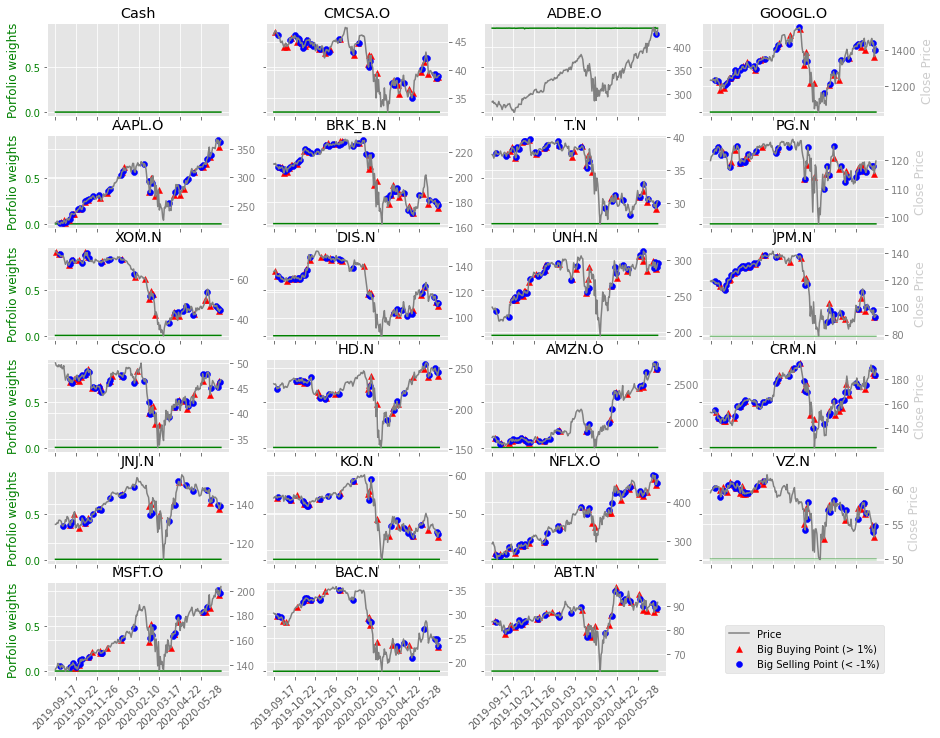

In [87]:
fig, axes = plt.subplots(nrows=6,ncols=4,sharex=True,sharey=True,figsize=(15,12))
for i in range(0,asset_number+1):
    row = i // 4
    col = i % 4
    ax = plot_ith_asset(axes[row,col],i,test_steps)
fig.delaxes(axes[5,3])
# fig.savefig('./figs/sell_buy_points.pdf',pad_inches=0)

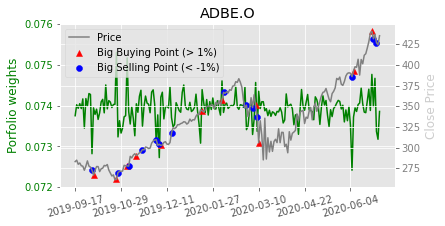

In [73]:
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(6,3))
i=2
start_date_index = timestamp_testing.index(test_start_date)
ax.set_title('%s'%(new_abbreviations[i]))
color = "green"
ax.plot(np.arange(0,test_steps),weights_matrix[0:,i],color=color)
ax.set_ylabel('Porfolio weights',color=color)
ax.set_ylim([0.072,0.076])
ax.tick_params(axis='y',labelcolor=color)

close_price = history_stock_price_testing[i-1,...][start_date_index:start_date_index+test_steps,3]
ax2 = ax.twinx()
color = "grey"
ax2.set_ylabel('Close Price',color=color,alpha=0.4)
ax2.plot(np.arange(0,test_steps),close_price,color=color,label='Price')
ax2.tick_params(axis='y',labelcolor=color)


buy_index = np.where((change[:,i] - 1) > 0.01)[0]+1
buy_price = close_price[buy_index]
ax2.scatter(buy_index,buy_price,c='r',label='Big Buying Point (> 1%)',marker='^')

sell_index = np.where((change[:,i] - 1) < -0.01)[0]+1
sell_price = close_price[sell_index]
ax2.scatter(sell_index,sell_price,c='b',label='Big Selling Point (< -1%)')
ax2.legend()

ax.set_xticks(np.arange(0,test_steps)[::30])
ax.set_xticklabels(envs_df['date'].to_numpy()[::30], rotation='15')
plt.savefig('./figs/case_study_adbe_weights.pdf',pad_inches=0)